In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM, Classifier, Regressor
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold

Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 1000000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 1000000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 100000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut":True ,
                "rec_cut_position": 1.2,
                "gen_cut_position":1.2
}

In [3]:
ToyModel = GaussianToy(data_params)

Define background subtraction classifier

In [4]:
bkg_true = torch.cat([ToyModel.data_rec[ToyModel.data_rec_mask.bool()], ToyModel.mc_background_rec[ToyModel.mc_background_mask.bool()]])
weights_true = torch.cat([torch.ones_like(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()]), torch.ones_like( ToyModel.mc_background_rec[ToyModel.mc_background_mask.bool()][:,0]) * -1])
bkg_false = ToyModel.data_rec[ToyModel.data_rec_mask.bool()]
weights_false = torch.ones_like(bkg_false[:,0])

In [5]:
background_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [6]:
background_classifier = Classifier(1, background_classifier_params)

In [7]:
background_classifier.train_classifier(bkg_true, bkg_false, weights_true, weights_false)

Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.264480471611023 after time 8.9
    Finished epoch 6 with average loss 1.2644253969192505 after time 57.6
    Finished epoch 12 with average loss 1.264583706855774 after time 106.4
    Finished epoch 18 with average loss 1.2642523050308228 after time 155.3
    Finished epoch 24 with average loss 1.2645306587219238 after time 204.3
    Finished epoch 29 with average loss 1.264344573020935 after time 245.6


In [8]:
background_weights = background_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
background_weights = background_weights * len(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()])/ background_weights.sum()

In [9]:
with PdfPages(f"Plots/background_suppression_interpolation.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal} |_r$" , "reweighted","data $(s+b)|_r$"], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:166: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


Define acceptance classifier

In [10]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [11]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [12]:
acceptance_classifier = Classifier(1, acceptance_classifier_params)

In [13]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 31.656222636768568
Training classifier for 930 epochs with lr 0.0001
    Finished epoch 0 with average loss 16.28765869140625 after time 0.3
    Finished epoch 186 with average loss 3.07328724861145 after time 45.5
    Finished epoch 372 with average loss 3.085240125656128 after time 90.5
    Finished epoch 558 with average loss 3.059483766555786 after time 135.4
    Finished epoch 744 with average loss 3.0525920391082764 after time 180.3
    Finished epoch 929 with average loss 3.0768420696258545 after time 225.0


In [14]:
acceptance = acceptance_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()], return_weights=False)

In [15]:
with PdfPages(f"Plots/acceptance_effects_interpolation.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=acceptance*background_weights,
                                 fake_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal}|_{g,r}$" , "$\epsilon$ (data -b)","data -b"], name="x_1")

Train CFM unfolding network

In [21]:
iterative_unfolding_params = { "iterations" : 5,
                               "generator": { "hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000},
                               "classifier": {"hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000}}

regressor_params =  { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000}

Starting with the 0.iteration.
Initalize unfolder
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.7363113760948181 after time 9.0
    Finished epoch 6 with average loss 0.6731473803520203 after time 59.7
    Finished epoch 12 with average loss 0.6724535226821899 after time 110.0
    Finished epoch 18 with average loss 0.672057032585144 after time 160.3
    Finished epoch 24 with average loss 0.6730459928512573 after time 210.3
    Finished epoch 29 with average loss 0.6699234247207642 after time 252.5
unfold data


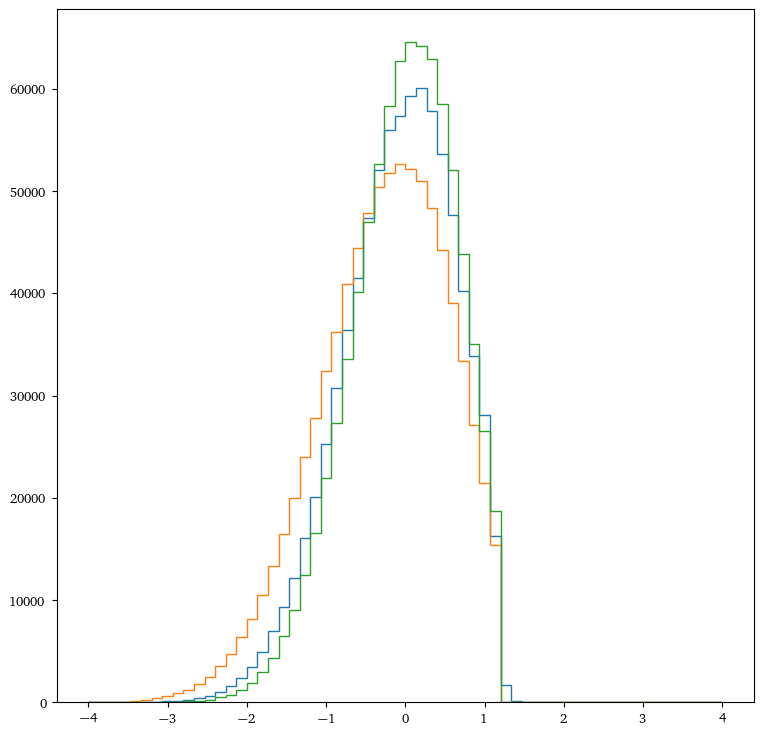

Starting with the 1.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2814383506774902 after time 12.0
    Finished epoch 6 with average loss 1.2797715663909912 after time 84.1
    Finished epoch 12 with average loss 1.279301643371582 after time 156.0
    Finished epoch 18 with average loss 1.279198169708252 after time 227.9
    Finished epoch 24 with average loss 1.2793071269989014 after time 300.9
    Finished epoch 29 with average loss 1.2791982889175415 after time 360.4
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.02620537206530571 after time 7.0
    Finished epoch 6 with average loss 0.0160156711935997 after time 49.3
    Finished epoch 12 with average loss 0.016002899035811424 after time 93.9
    Finished epoch 18 with average loss 0.01599637046456337 after time 136.7
    Finished epoch 24 with average loss 0.015991641208529472 after time 179.4
    Finished epoch 29 with average loss 0

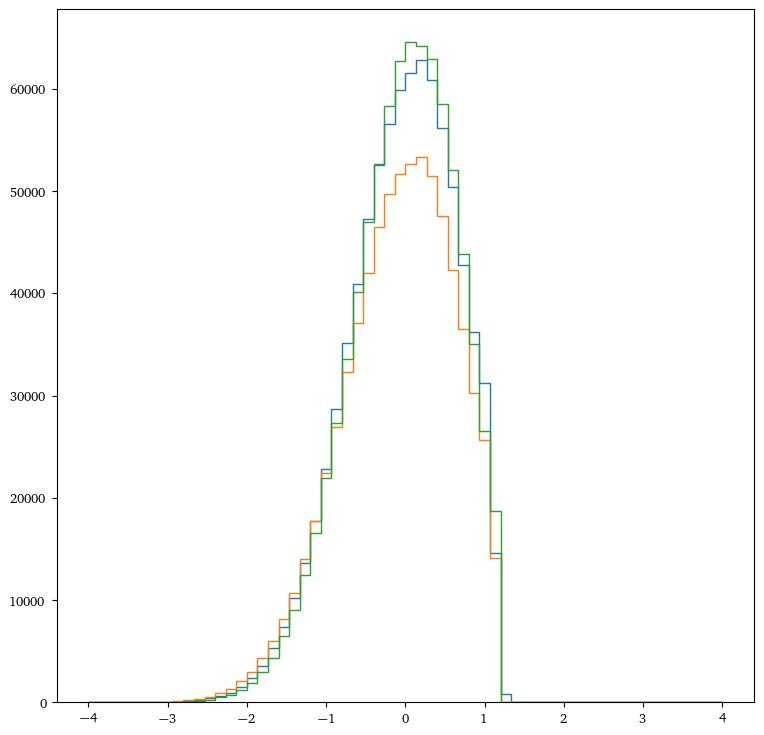

Starting with the 2.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2180969715118408 after time 12.2
    Finished epoch 6 with average loss 1.2174936532974243 after time 83.6
    Finished epoch 12 with average loss 1.2174630165100098 after time 155.8
    Finished epoch 18 with average loss 1.2174088954925537 after time 226.9
    Finished epoch 24 with average loss 1.2174140214920044 after time 298.1
    Finished epoch 29 with average loss 1.2173961400985718 after time 357.5
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.039188552647829056 after time 7.1
    Finished epoch 6 with average loss 0.026278570294380188 after time 49.3
    Finished epoch 12 with average loss 0.026264183223247528 after time 91.4
    Finished epoch 18 with average loss 0.026263559237122536 after time 134.1
    Finished epoch 24 with average loss 0.02625262178480625 after time 176.6
    Finished epoch 29 with average l

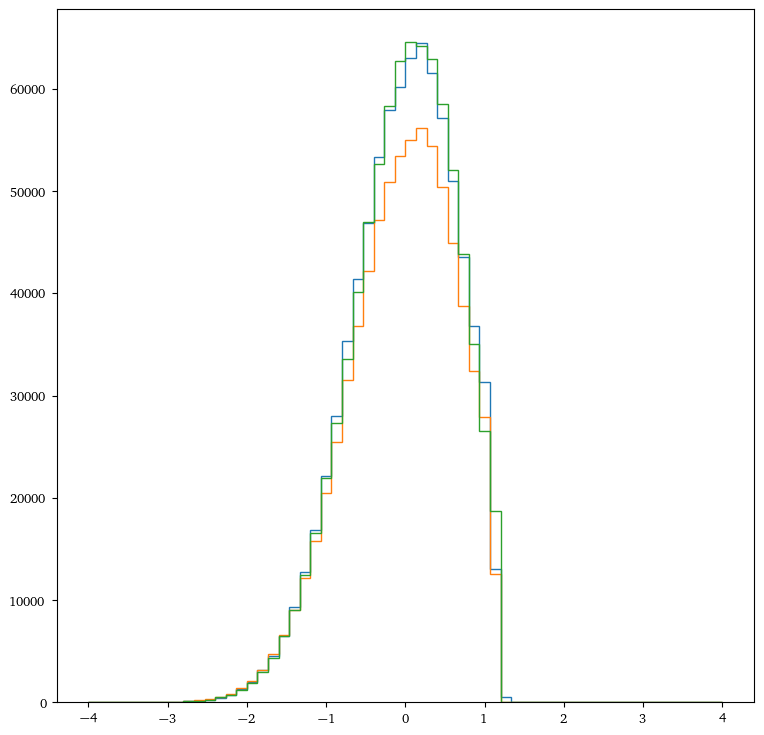

Starting with the 3.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.224178433418274 after time 14.0
    Finished epoch 6 with average loss 1.2241344451904297 after time 92.9
    Finished epoch 12 with average loss 1.224120020866394 after time 175.5
    Finished epoch 18 with average loss 1.2238726615905762 after time 259.7
    Finished epoch 24 with average loss 1.2238459587097168 after time 338.8
    Finished epoch 29 with average loss 1.223844051361084 after time 408.1
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.043749965727329254 after time 8.5
    Finished epoch 6 with average loss 0.029666878283023834 after time 59.1
    Finished epoch 12 with average loss 0.029655372723937035 after time 108.7
    Finished epoch 18 with average loss 0.029637126252055168 after time 159.7
    Finished epoch 24 with average loss 0.02963644079864025 after time 210.2
    Finished epoch 29 with average los

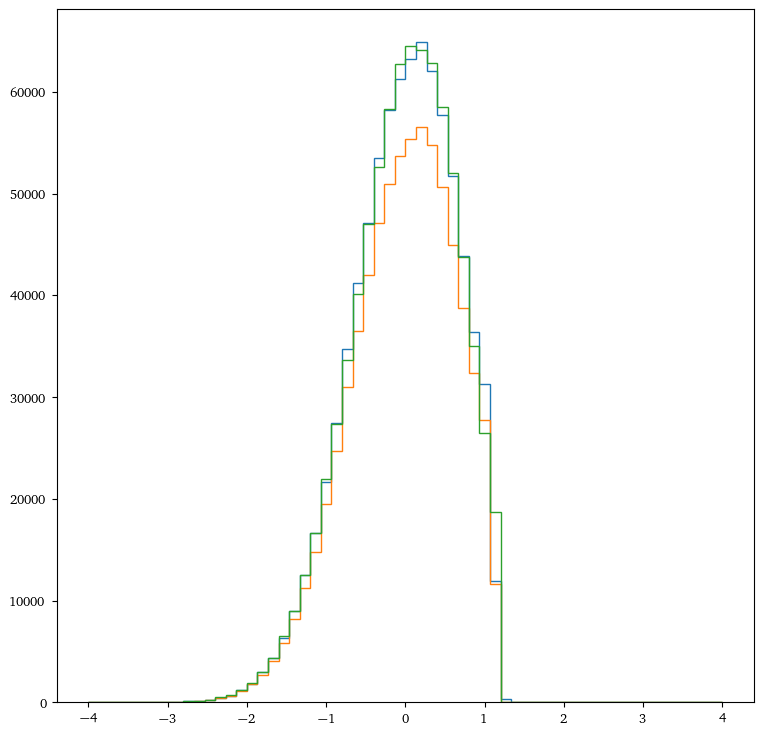

Starting with the 4.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.216996669769287 after time 16.2
    Finished epoch 6 with average loss 1.2170281410217285 after time 95.6
    Finished epoch 12 with average loss 1.2170041799545288 after time 172.3
    Finished epoch 18 with average loss 1.2169984579086304 after time 244.3
    Finished epoch 24 with average loss 1.2170029878616333 after time 321.9
    Finished epoch 29 with average loss 1.2170056104660034 after time 388.8
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.04246901348233223 after time 8.0
    Finished epoch 6 with average loss 0.031132914125919342 after time 56.1
    Finished epoch 12 with average loss 0.03111363761126995 after time 104.3
    Finished epoch 18 with average loss 0.031107790768146515 after time 152.3
    Finished epoch 24 with average loss 0.031101597473025322 after time 200.2
    Finished epoch 29 with average lo

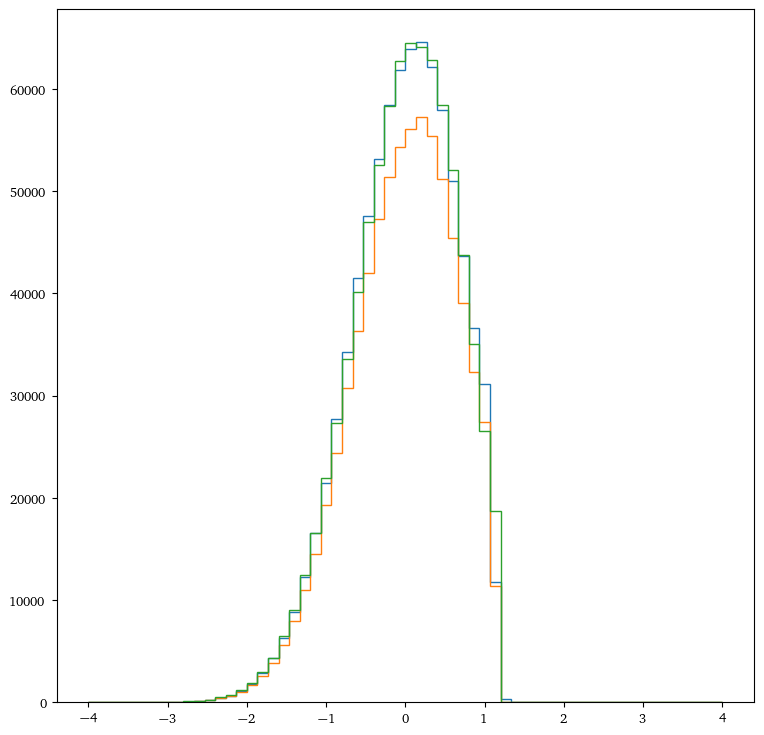

In [24]:
# print("Initalize unfolder")
# unfolder = CFM(1, 1, iterative_unfolding_params["generator"])
# print("Initalize classifier")
# iterative_classifier = Classifier(1, iterative_unfolding_params["classifier"])
# print("Initalize regressor")
# iterative_regressor = Regressor(1, regressor_params)
for i in range(iterative_unfolding_params["iterations"]):
    print(f"Starting with the {i}.iteration.")
    if i == 0:
        print("Initalize unfolder")
        unfolder = CFM(1, 1, iterative_unfolding_params["generator"])
        mc_gen = ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_rec = ToyModel.mc_rec[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_weights = torch.ones_like(mc_rec[:, 0])
        data_weights = acceptance * background_weights
    if i > 0 :
        iterative_classifier = Classifier(1, iterative_unfolding_params["classifier"])
        iterative_classifier.train_classifier(data_unfold, mc_gen, data_weights, mc_weights)
        mc_weights *= iterative_classifier.evaluate(mc_gen)
        iterative_regressor = Regressor(1, regressor_params)
        iterative_regressor.train_regressor(mc_rec, mc_weights)
        mc_interpolated_weights = iterative_regressor.evaluate(ToyModel.mc_rec[(~ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())])
        acceptance_classifier.train_classifier(acceptance_true, acceptance_false, weights_true=mc_weights, weights_false=mc_interpolated_weights, balanced=False)
        acceptance = acceptance_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()], return_weights=False)
        with PdfPages(f"Plots/acceptance_effects_interpolation_{i}.pdf") as out:
            plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=acceptance*background_weights,
                                 fake_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal}|_{g,r}$" , "$\epsilon$ (data -b)","data -b"], name="x_1")
        data_weights = acceptance * background_weights
    unfolder.train_unfolder(mc_gen, mc_rec, mc_weights)
    print("unfold data")
    data_unfold = unfolder.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
    fig, axes = plt.subplots()
    axes.hist(data_unfold[:,0], weights=data_weights, bins=60, histtype="step", range=[-4,4])
    axes.hist(mc_gen[:,0], weights=mc_weights, bins=60, histtype='step', range=[-4,4])
    axes.hist(ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool())&(ToyModel.data_gen_mask.bool())], bins=60, range=[-4,4], histtype="step")
    plt.show()

In [30]:
with PdfPages(f"Plots/prior_dependence_cut.pdf") as out:
    plot_prior_unfold(out, ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],ToyModel.mc_gen[:,0][(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())],
                                 data_unfold[:, 0],
                      unfolded_weights=acceptance*background_weights,
                                 range=[-3,4], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:272: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:273: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:272: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


Train efficiency classifier

In [25]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [26]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) ]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) ]

In [27]:
efficiency_classifier = Classifier(1, efficiency_classifier_params)

In [28]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 6.031409305367075
Training classifier for 180 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.7466360330581665 after time 2.6
    Finished epoch 36 with average loss 1.271129846572876 after time 77.4
    Finished epoch 72 with average loss 1.2790850400924683 after time 152.8
    Finished epoch 108 with average loss 1.2727556228637695 after time 226.9
    Finished epoch 144 with average loss 1.2713375091552734 after time 301.4
    Finished epoch 179 with average loss 1.2746410369873047 after time 373.3


In [29]:
efficiency = efficiency_classifier.evaluate(data_unfold, return_weights=False)

In [30]:
data_weights =acceptance* background_weights/ efficiency

In [31]:
with PdfPages(f"Plots/efficiency_effects_interpolation.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_gen[:,0][(ToyModel.data_gen_mask.bool())],
                                 data_unfold[:,0],
                                 data_unfold[:,0],
                                 reweighted_weights=acceptance*background_weights/efficiency,
                                 fake_weights=acceptance*background_weights,
                                 range=[-3,4], labels=[r"$\text{gen}|_g$" , r"$\text{unfolded} / \delta$","unfolded"], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:166: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:165: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


In [32]:
with PdfPages(f"Plots/final_unfolding_interpolation.pdf") as out:
    plot_naive_unfold(out, ToyModel.data_gen[:, 0][
       (ToyModel.data_gen_mask.bool())],
                       ToyModel.data_rec[:, 0],
                      data_unfold[:, 0],
                        unfolded_weights=data_weights,
                      range=[-3, 4], name="x_1")

/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:56: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:57: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)
/Users/sofia/Projects/Full_Generative_Unfolding/plots.py:56: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
